# 9.4 Model selection with correlational data
In this notebook we show how to use modular structure as model selection criterion when thresholding a correlation network. We do this using the codelength savings (description length compression) $\frac{L(1)-L(M)}{L(1)}$, where $L(1)$ is the codelength with a 1-level (uncompressed) partition and $L(M)$ is the maximally compressed codelength using the optimal partition $M$. We crossvalidate the threshold $\tau$ and evaluate each threshold (model) through the codelength savings in the test network given the model (partition) based on the training data, and choose the best threshold $\tau^*$ such that $\tau^*=\mathrm{argmax}_\tau\frac{L^{\tau,test}(1)-L^{\tau,test}(M^{\tau,train})}{L^{\tau,test}(1)}$. This threshold gives the best balance between over- and underfitting modular structure to data.

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import infomap
from sklearn.metrics import adjusted_mutual_info_score

In [61]:
def blockCov(num_blocks, block_size, covariance):
    # block diagonal matrix to use as covariance matrix in multivariate normal distribution
    block = np.full((block_size, block_size), covariance)
    np.fill_diagonal(block, 1)
    return np.block([[block if i==j else np.zeros((block_size, block_size)) for j in range(num_blocks)] for i in range(num_blocks)])

In [200]:
def codelength_savings(sample, thresholds):
    # crossvalidate the threshold to find the best balance between over and underfitting modular structure to data
    train_codelength_savings = []
    test_codelength_savings  = []
    codelength_savings_best  = 0
    sample_df = pd.DataFrame(data=sample)
    for threshold in thresholds:
        # 2-fold splitting of samples
        train_df = sample_df.sample(frac=0.5, axis = 0)
        test_df=sample_df.drop(train_df.index)
        # make training network and run Infomap
        sample_train = train_df.to_numpy(copy=True)
        sample_test = test_df.to_numpy(copy=True)
        
        r_train = np.dot(sample_train.T, sample_train) / sample_train.shape[0]
        np.fill_diagonal(r_train, 0)
        G_train = nx.from_numpy_matrix(np.abs(r_train * (r_train > threshold)))
        #G_train = nx.from_numpy_matrix(r_train * (r_train > threshold))
        
        infomap_train = infomap.Infomap(silent = True, two_level = True)
        infomap_train.add_networkx_graph(G_train)
        infomap_train.run()
        train_codelength_savings.append(infomap_train.relative_codelength_savings)
        # make test network and run Infomap with the modules from the training network
        r_test = np.dot(sample_test.T, sample_test) / sample_test.shape[0]
        np.fill_diagonal(r_test, 0)
        G_test = nx.from_numpy_matrix(np.abs(r_test * (r_test > threshold)))
        #G_test = nx.from_numpy_matrix(r_test * (r_test > threshold))
        
        infomap_test = infomap.Infomap(silent = True, two_level = True, no_infomap = True)
        infomap_test.add_networkx_graph(G_test)
        infomap_test.run(initial_partition = dict(infomap_train.modules))
        test_codelength_savings.append(infomap_test.relative_codelength_savings)
        if infomap_test.relative_codelength_savings > codelength_savings_best:
            codelength_savings_best = infomap_test.relative_codelength_savings
    return train_codelength_savings, test_codelength_savings 

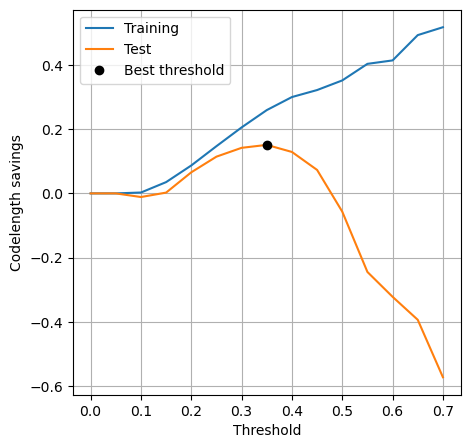

In [201]:
# sample multivariate data with planted modular structure
planted_cov = 0.3
nSamples = 100
nModules = 8
nNodesPerModule = 30

cov = blockCov(nModules, nNodesPerModule, planted_cov)
mean = np.zeros((nModules*nNodesPerModule,))
sample = np.random.multivariate_normal(mean, cov, size = nSamples)
plantedPartition = []
for i in range(1,nModules+1):
    plantedPartition += np.full(nNodesPerModule, i).tolist()
# do repeated cross validation to find the threshold that gives
# the best balance between over and underfitting modular structure to data
thresholds = np.arange(0,0.75, 0.05)
nRuns = 10
train_codelength_savings, test_codelength_savings = np.zeros((1, len(thresholds))), np.zeros((1, len(thresholds)))
for _ in range(0, nRuns):
    train_codelength_savings_, test_codelength_savings_ = codelength_savings(sample, thresholds)
    train_codelength_savings+=train_codelength_savings_
    test_codelength_savings+=test_codelength_savings_
threshold_best = thresholds[test_codelength_savings.argmax()]
fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.plot(thresholds, train_codelength_savings[0]/nRuns, label='Training')
ax.plot(thresholds, test_codelength_savings[0]/nRuns, label='Test')
ax.plot(threshold_best, test_codelength_savings.max()/nRuns, 'ko', label='Best threshold')
ax.grid(), ax.legend(), ax.set_xlabel('Threshold'), ax.set_ylabel('Codelength savings');

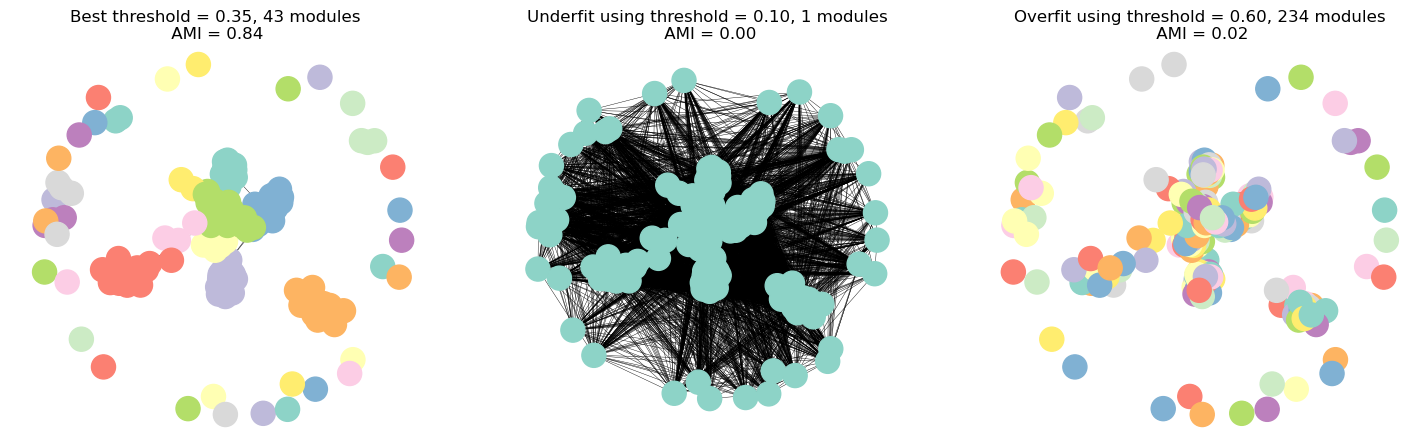

In [202]:
# plot networks with modules, including underfit and overfit of modules to data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,5))
r = np.abs(np.dot(sample.T, sample) / sample.shape[0])#np.dot(sample.T, sample) / sample.shape[0]
# use the threshold found above
threshold = threshold_best
np.fill_diagonal(r, 0)
G_best = nx.from_numpy_matrix(r * (r > threshold))
im = infomap.Infomap(silent = True, two_level = True)
im.add_networkx_graph(G_best)
im.run()
nodelist = G_best.nodes
modules = dict(im.modules)
num_modules = im.num_top_modules
pos = nx.spring_layout(G_best)
AMI = adjusted_mutual_info_score(list(modules.values()), plantedPartition)
nx.draw(G_best, pos = pos, ax = ax1, node_color = [sns.color_palette('Set3', n_colors=num_modules)[modules[node]-1] for node in nodelist], width = 0.3)
ax1.axis("off"), ax1.set_title(f"Best threshold = {threshold_best:.2f}, {num_modules} modules\n AMI = {AMI:.2f}")
# underfit the modular structure to the data
threshold = 0.1
G_underfit = nx.from_numpy_matrix(r * (r > threshold))
im = infomap.Infomap(silent = True, two_level = True)
im.add_networkx_graph(G_underfit)
im.run()
nodelist = G_underfit.nodes
modules = dict(im.modules)
num_modules = im.num_top_modules
AMI = adjusted_mutual_info_score(list(modules.values()), plantedPartition)
nx.draw(G_underfit, pos = pos, ax = ax2, node_color = [sns.color_palette('Set3', n_colors=num_modules)[modules[node]-1] for node in nodelist], width = 0.3)
ax2.axis("off"), ax2.set_title(f"Underfit using threshold = {threshold:.2f}, {num_modules} modules\n AMI = {AMI:.2f}")
# overfit the modular structure to the data
threshold = 0.6
G_overfit = nx.from_numpy_matrix(r * (r > threshold))
im = infomap.Infomap(silent = True, two_level = True)
im.add_networkx_graph(G_overfit)
im.run()
nodelist = G_overfit.nodes
modules = dict(im.modules)
num_modules = im.num_top_modules
nx.draw(G_overfit, pos = pos, ax = ax3, node_color = [sns.color_palette('Set3', n_colors=num_modules)[modules[node]-1] for node in nodelist], width = 0.3)
AMI = adjusted_mutual_info_score(list(modules.values()), plantedPartition)
ax3.axis("off"), ax3.set_title(f"Overfit using threshold = {threshold:.2f}, {num_modules} modules\n AMI = {AMI:.2f}");